In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_on_random, evaluate_on_data, evaluate_on_images, 
    plot_calculation_times_and_niter,
    to_image
)

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

## Evaluate All Algorithms


Testing on random generated tensors:
Dimension of tensor: (10, 10, 10), noise: 0, F: 3, norm: 407.8510291908072
Multiplicative converged in 0.812 seconds and 695 iterations
Multiplicative Poisson converged in 0.764 seconds and 500 iterations
Norm of tensor: 407.8510291908072, norm of approx: 407.82563078880384, norm of difference: 1.3997140234177743
Geometric Algorithm converged in 1.012 seconds and 169 iterations
Dimension of tensor: (20, 20, 5), noise: 0.06801199750121119, F: 2, norm: 245.78444095872064
Multiplicative converged in 0.624 seconds and 502 iterations
Multiplicative Poisson converged in 0.248 seconds and 192 iterations
Norm of tensor: 245.7844409587206, norm of approx: 242.43638092969533, norm of difference: 19.323096198930646
Geometric Algorithm converged in 0.945 seconds and 139 iterations
Dimension of tensor: (10, 10, 10, 5), noise: 0.19424776322658382, F: 5, norm: 217.9642624367751
Multiplicative converged in 1.283 seconds and 526 iterations
Multiplicative Poisson co

C:\Users\David\Documents\GitHub\GeometricTensorFactorization\tensorfactorization\poisson.py:150: BacktrackingWarning: Backtracking did not converge in time so we skip this update.
  warnings.warn("Backtracking did not converge in time so we skip this update.", BacktrackingWarning)


Norm of tensor: 75562.138105006, norm of approx: 75983.53661059204, norm of difference: 6659.875461938818
Geometric Algorithm converged in 17.881 seconds and 132 iterations

Factorizing image cat with F = 6
Multiplicative converged in 3.231 seconds and 545 iterations
Multiplicative Poisson converged in 1.837 seconds and 582 iterations
Norm of tensor: 78242.36685453732, norm of approx: 77072.25165074274, norm of difference: 14468.60673136639
Geometric Algorithm converged in 0.858 seconds and 57 iterations

Factorizing image coffee with F = 6
Multiplicative converged in 3.131 seconds and 317 iterations
Multiplicative Poisson converged in 1.873 seconds and 405 iterations
Norm of tensor: 104658.42702334104, norm of approx: 101870.02386124303, norm of difference: 26915.588820885365
Geometric Algorithm converged in 4.604 seconds and 196 iterations

Factorizing image astronaut with F = 9
Multiplicative converged in 10.887 seconds and 934 iterations
Multiplicative Poisson converged in 3.915 se

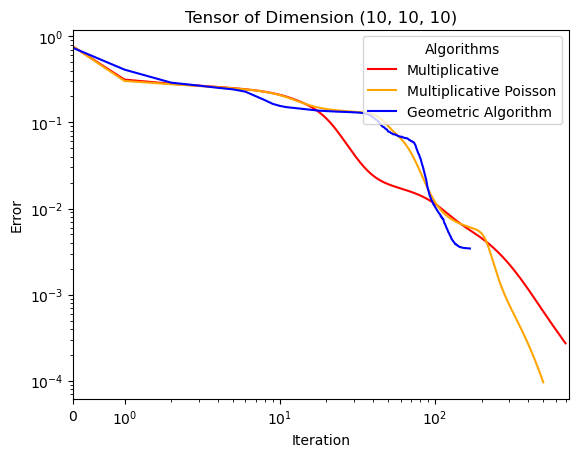

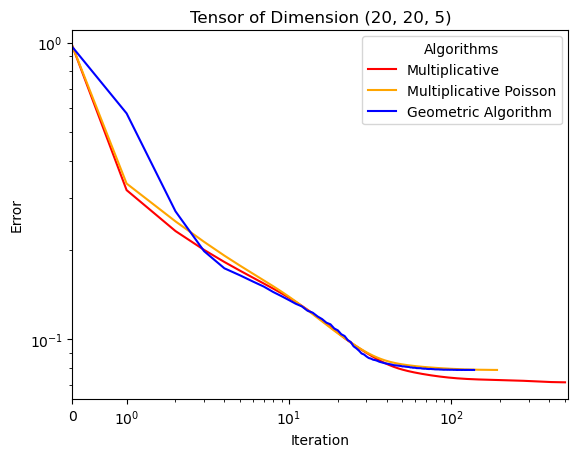

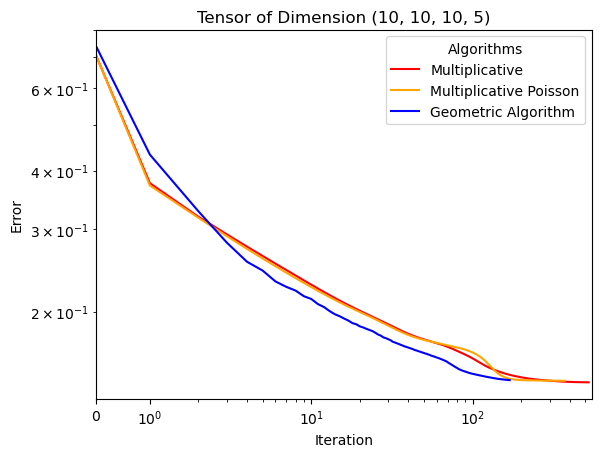

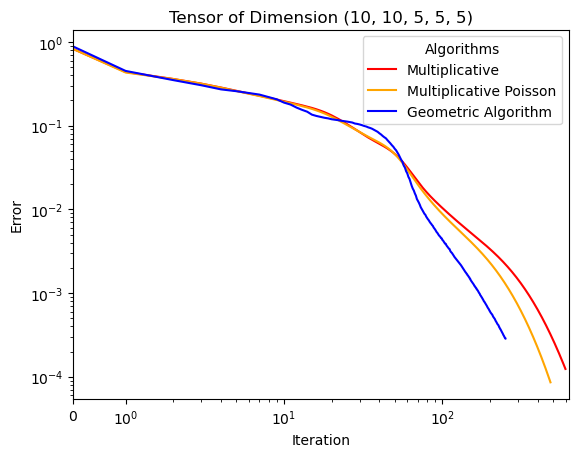

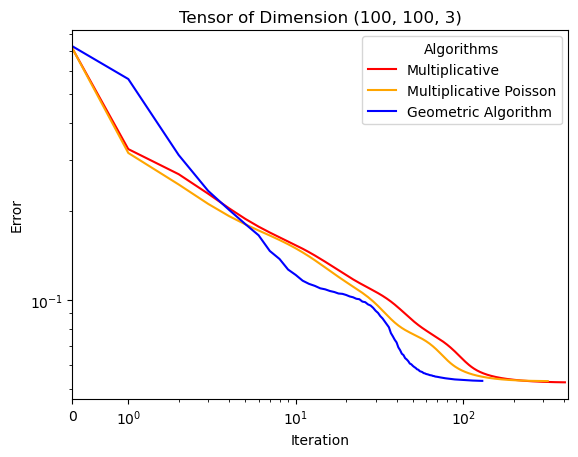

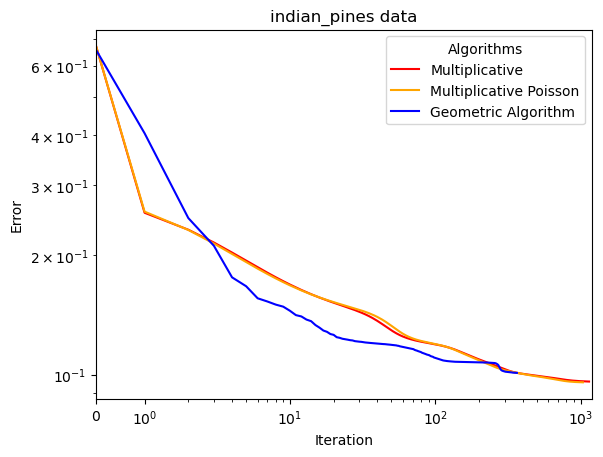

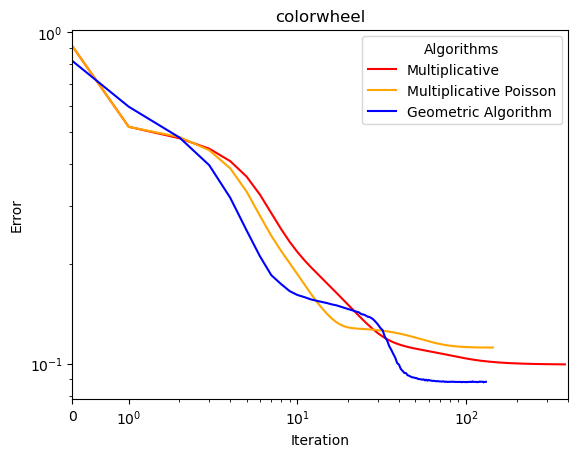

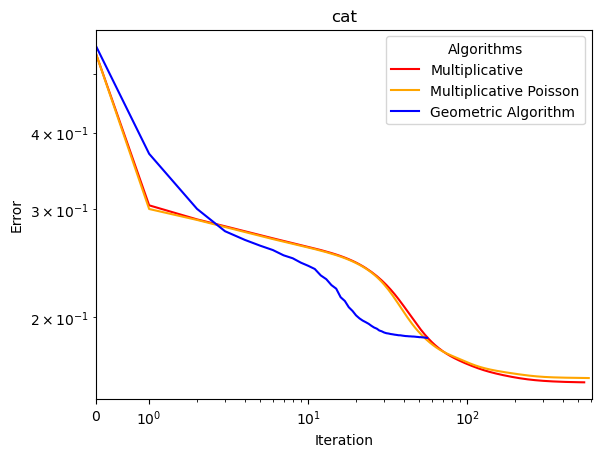

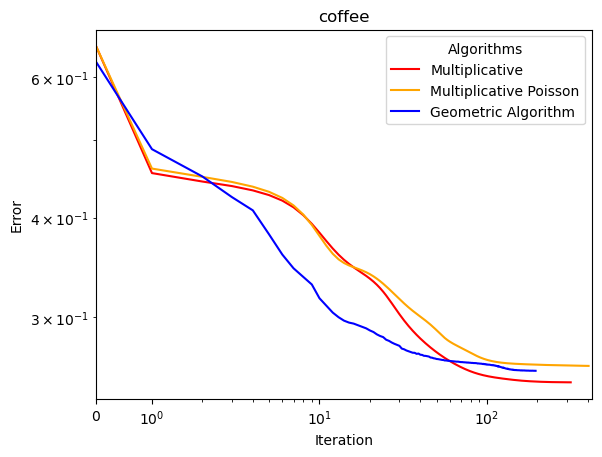

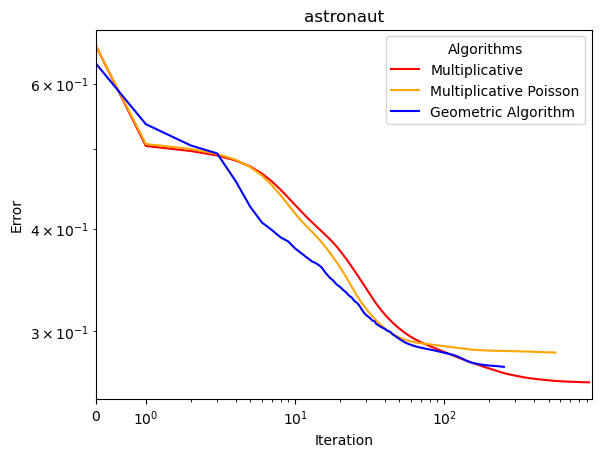

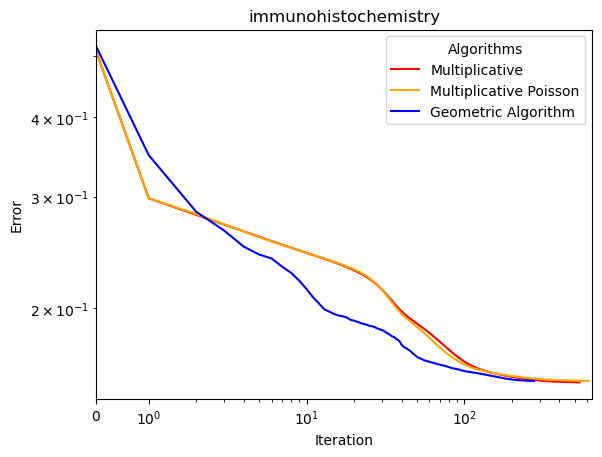

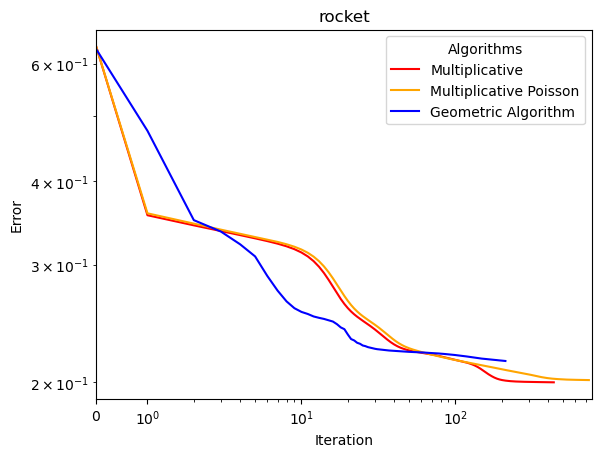

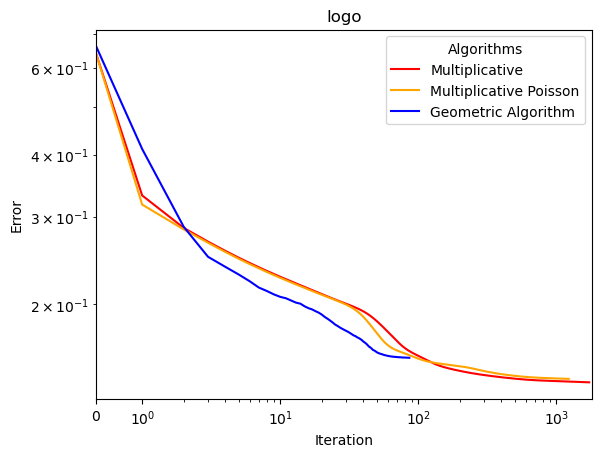

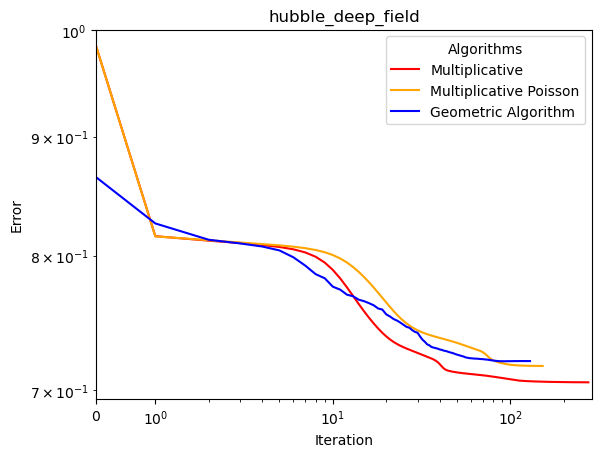

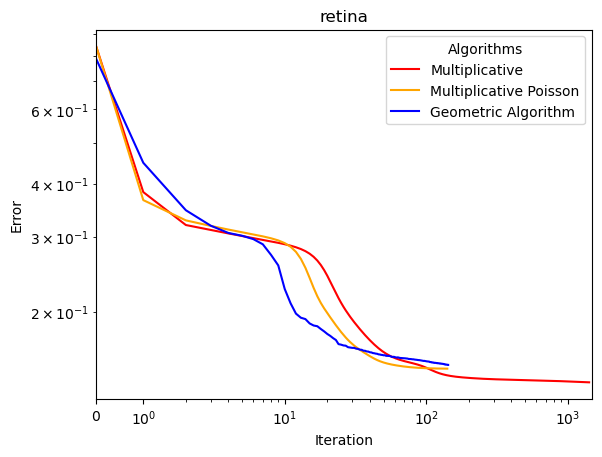

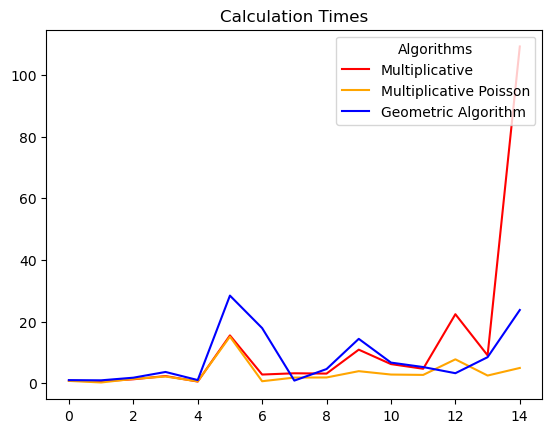

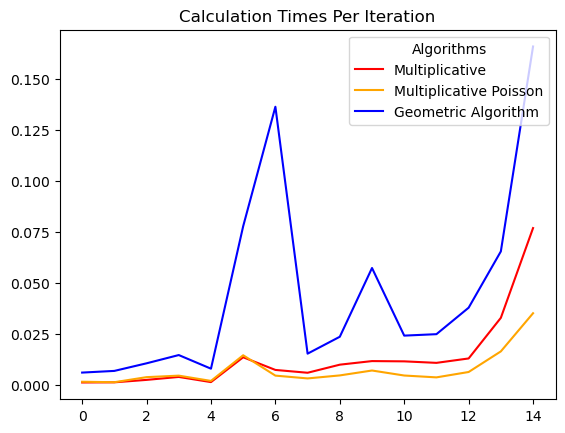

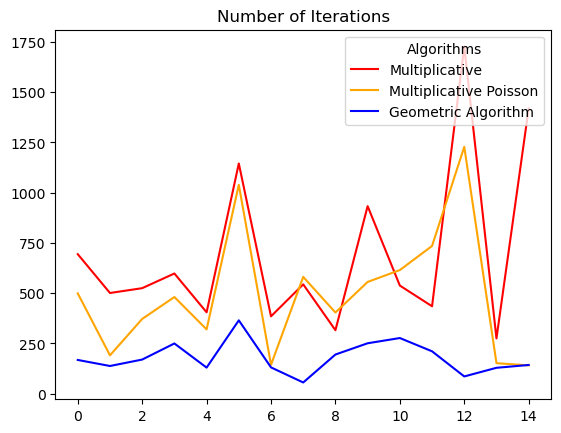

In [7]:
# CREATE FACTORIZER OBJECTS FOR ALL ALGORITHMS
max_iter = 2000

# The standart multiplicative algorithm
def multiplicative_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

# The Poisson variant of the multiplicative algorithm
def multiplicative_poisson_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')


# The new geometric algorithm with step size calculation and without any form of normalization
def geometric_variable_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric = Factorizer("Geometric step size calculation without rescaling", geometric_variable_step_size, color='blue')

# The new geometric algorithm with step size calculation and but normalization of the tensor and the initial data
def geometric_variable_normalized(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    norm_of_tensor = tl.norm(tensor)
    tensor_copy = tensor / norm_of_tensor # normalize tensor
    norm_of_approximation = tl.norm(defactorizing_CP(initial_A_ns, tensor.shape))
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / norm_of_approximation) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_norm = Factorizer("Geometric step size calculation with normalization", geometric_variable_normalized, color='blue', linestyle='dotted')

# The new geometric algorithm with step size calculation and but max=1 of the tensor and the initial data
def geometric_variable_normalize_max(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.max(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.max(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_max = Factorizer("Geometric step size calculation with max = 1", geometric_variable_normalize_max, color='blue', linestyle='dashed')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_variable_normalize_mean(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_mean = tl.mean(tensor)
    tensor_copy = tensor / tensor_mean # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    # rescale the A_ns to the original scaling so that we have comparitability
    scaling = tensor_mean ** (1.0/ tensor.ndim)
    for n in range(len(A_ns)):
        A_ns[n] = A_ns[n] * scaling
    print(f"Norm of tensor: {tl.norm(tensor)}, norm of approx: {tl.norm(defactorizing_CP(A_ns, tensor.shape))}, norm of difference: {tl.norm(tensor - defactorizing_CP(A_ns, tensor.shape))}")
    return IterationResult(tl.tensor(RE), end-start, A_ns)
#factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')
factorizer_geometric_mean = Factorizer("Geometric Algorithm", geometric_variable_normalize_mean, color='blue', linestyle='solid')


# default geometric algorithm with fixed step size. Use normalize the mean of the tensor to get some form of normalization
def geometric_fixed_step_size(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_fixed_step_size(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_fixed = Factorizer("Geometric fixed step size", geometric_fixed_step_size, color='green')


# run the factorization on gpu
tl.set_backend('pytorch')
context = {'dtype': tl.float64,
           'device': 'cuda'}
#context = {}
factorizers = [
    factorizer_multiplicative,
    factorizer_multiplicative_poisson,
    #factorizer_geometric,
    #factorizer_geometric_norm,
    #factorizer_geometric_max,
    factorizer_geometric_mean,
    #factorizer_geometric_fixed,
]
evaluate_on_random(factorizers, context=context)
evaluate_on_data(factorizers, context=context)
evaluate_on_images(factorizers, context=context)
plot_calculation_times_and_niter(factorizers)

# Show the Factor Parts of Decomposition

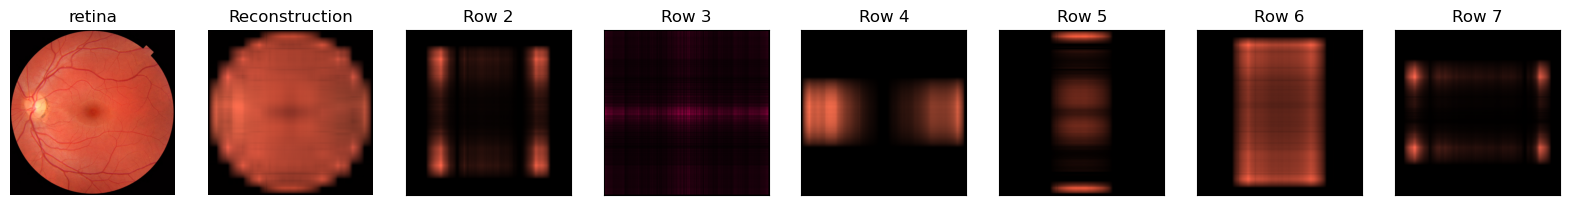

In [23]:
from skimage import data
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

tensor = tl.tensor(data.retina(), **context)
#tensor = random_cp_with_noise((10,10,10), 2)
J = 6
initial_Ans = create_initial_data(tensor, J)
result = geometric_variable_normalize_mean(tensor, J, initial_Ans)


fig, axes = plt.subplots(nrows=1, ncols=J+2, figsize=(20,20))
axes[0].set_title("retina")
axes[0].set_axis_off()
axes[0].imshow(to_image(tensor))

axes[1].set_title("Reconstruction")
axes[1].set_axis_off()
axes[1].imshow(to_image(defactorizing_CP(result.A_ns, tensor.shape)))

for index in range(2,J+2):
    columns = []
    for A_n in result.A_ns:
        columns.append(A_n[:,index-2])
    rank1_tensor = tl.tenalg.outer(columns)
    axes[index].set_title(f"Component {index-1}")
    axes[index].set_xticks([])
    axes[index].set_yticks([])
    axes[index].imshow(to_image(rank1_tensor))

#fig.show()